In [1]:
import numpy as np
import gym
import copy

import typing
import quadruped_gym.gym
from quadruped_gym.core.simulator import Controller, Simulator
from quadruped_gym.core.types import RobotObservation, RobotAction
from quadruped_gym.gym.env_builder import A1BulletGymEnv
from quadruped_gym.quadruped import a1_pybullet
from quadruped_gym.quadruped.a1_pybullet.simulator import SimulationParameters  # noqa: F401

class Logger:

    def __init__(self):
        self.data = []

    def update(self, data: typing.Union[np.ndarray, RobotAction, RobotObservation]):
        self.data.append(data)

    def collate(self):
        if isinstance(self.data[0], np.ndarray):
            all_data = np.stack(self.data, axis=0)
        elif isinstance(self.data[0], RobotAction):
            all_data = RobotAction(
                desired_motor_angles = np.stack([act.desired_motor_angles for act in self.data]),
                desired_motor_velocities = np.stack([act.desired_motor_velocities for act in self.data]),
                position_gain = np.stack([act.position_gain for act in self.data]),
                velocity_gain = np.stack([act.velocity_gain for act in self.data]),
                additional_torques = np.stack([act.additional_torques for act in self.data])
            )
        else:
            all_data = RobotObservation(
                base_position = np.stack([obs.base_position for obs in self.data]),
                base_velocity = np.stack([obs.base_velocity for obs in self.data]),
                base_orientation = np.stack([obs.base_orientation for obs in self.data]),
                base_rpy = np.stack([obs.base_rpy for obs in self.data]),
                base_rpy_rate = np.stack([obs.base_rpy_rate for obs in self.data]),
                motor_angles = np.stack([obs.motor_angles for obs in self.data]),
                motor_velocities = np.stack([obs.motor_velocities for obs in self.data]),
                motor_torques = np.stack([obs.motor_torques for obs in self.data]),
                foot_contacts = np.stack([obs.foot_contacts for obs in self.data]),
                foot_contact_forces = np.stack([obs.foot_contact_forces for obs in self.data]),
                foot_positions = np.stack([obs.foot_positions for obs in self.data]),
            )
        return all_data   

def test_simulation_with_controller(simulator: Simulator, controller: Controller, n_time_steps = 100):
    obs_logger = Logger()
    act_logger = Logger()

    obs = simulator.reset()
    for i in range(n_time_steps):
        controller.update(i * simulator.sim_params.n_action_repeat, obs)
        action = controller.get_action()
        obs_logger.update(copy.deepcopy(obs))
        act_logger.update(copy.deepcopy(action))
        obs = simulator.step(action)

    observation_history = obs_logger.collate()
    action_history = act_logger.collate()
    return observation_history, action_history

pybullet build time: Dec  1 2021 18:33:43


In [2]:
from quadruped_gym.agents.linear_controller import LinearController

SIM_TIME_STEP = 0.001
N_ACTION_REPEAT = 10
N_TIME_STEPS = 1000

simulator = a1_pybullet.A1PyBulletSimulator(
    sim_params=SimulationParameters(
        sim_time_step_s = SIM_TIME_STEP,
        n_action_repeat = N_ACTION_REPEAT,
        enable_rendering=True,
        enable_clip_motor_commands=False,
        enable_action_filter=False)
)
controller = LinearController(
    init_pose = np.array([0, 0.67, -1.3] * 4),
    final_pose = np.array([0, 1.0, -2.0] * 4), 
    controller_kp = 0.2,  
    controller_kd = 1.0,
    interpolation_timesteps = 1000
)


obs_hist, act_hist = test_simulation_with_controller(
    simulator, controller, n_time_steps= N_TIME_STEPS)

del simulator

argv[0]=
startThreads creating 1 threads.
starting thread 0
started thread 0 
argc=3
argv[0] = --unused
argv[1] = 
argv[2] = --start_demo_name=Physics Server
ExampleBrowserThreadFunc started
X11 functions dynamically loaded using dlopen/dlsym OK!
X11 functions dynamically loaded using dlopen/dlsym OK!
Creating context
Created GL 3.3 context
Direct GLX rendering context obtained
Making context current
GL_VENDOR=NVIDIA Corporation
GL_RENDERER=NVIDIA GeForce RTX 3070 Laptop GPU/PCIe/SSE2
GL_VERSION=3.3.0 NVIDIA 515.65.01
GL_SHADING_LANGUAGE_VERSION=3.30 NVIDIA via Cg compiler
pthread_getconcurrency()=0
Version = 3.3.0 NVIDIA 515.65.01
Vendor = NVIDIA Corporation
Renderer = NVIDIA GeForce RTX 3070 Laptop GPU/PCIe/SSE2
b3Printf: Selected demo: Physics Server
startThreads creating 1 threads.
starting thread 0
started thread 0 
MotionThreadFunc thread started
b3Printf: b3Warning[examples/Importers/ImportURDFDemo/BulletUrdfImporter.cpp,126]:

b3Printf: No inertial data for link, using mass=1, 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


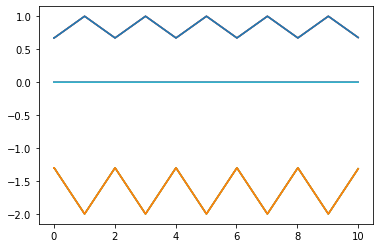

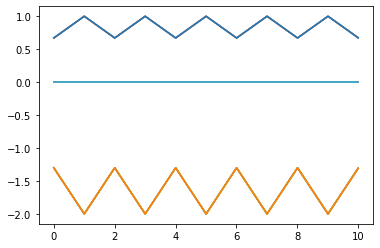

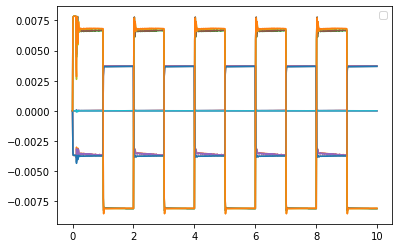

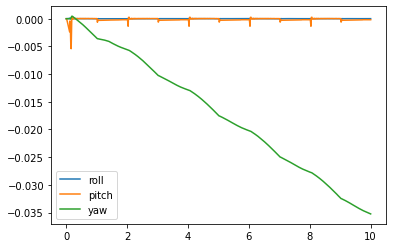

In [3]:
import matplotlib.pyplot as plt 

time = np.linspace(0, N_TIME_STEPS * N_ACTION_REPEAT * SIM_TIME_STEP, N_TIME_STEPS)

plt.figure()
for i in range(obs_hist.motor_angles.shape[1]):
    plt.plot(time, obs_hist.motor_angles[:,i])

plt.figure()
for i in range(obs_hist.motor_angles.shape[1]):
    plt.plot(time, act_hist.desired_motor_angles[:,i])

plt.figure()
for i in range(obs_hist.motor_angles.shape[1]):
    plt.plot(time, obs_hist.motor_angles[:,i] - act_hist.desired_motor_angles[:,i])
plt.legend()

plt.figure()
for i in range(3):
    plt.plot(time, obs_hist.base_rpy[:,i], label = ['roll', 'pitch', 'yaw'][i])
plt.legend()